# Fine-tuning and transfer learning

## MobileNet Image Classification With Keras


### MobileNet

MobileNets are a class of small, low-latency, low-power models that can be used for classification, detection, and other common tasks convolutional neural networks are good for. Because of their small size, these are considered great deep learning models to be used on mobile devices.


### Comparing MobileNets To Other Models
To give a quick comparison in regards to size, the size of the full VGG16 network on disk is about 553 megabytes. The size of one of the currently largest MobileNets is about 17 megabytes, so that is a huge difference, especially when you think about deploying a model to a mobile app or running it in the browser.

This vast size difference is due to the number of parameters within these networks. For example, VGG16 has 138 million parameters, while the 17 megabyte MobileNet we just mentioned has only 4.2 million.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

We first make a call to tf.keras.applications.mobilenet.MobileNet() to obtain a copy of a single pretrained MobileNet with weights that were saved from being trained on ImageNet images. We’re assigning this model to the variable mobile.

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 51s 3us/step


We have a function called prepare_image() that accepts an image file, and processes the image to get it in a format that the model expects. We’ll be passing each of our images to this function before we use MobileNet to predict on it.

* We then call the Keras function image.load_img() which accepts the image file and a target_size for the image, which we’re setting to (224,224) (which is the default size for MobileNet). load_img() returns an instance of a PIL image.

* We then convert the PIL image into an array with the Keras img_to_array() function, and then we expand the dimensions of that array by using numpy’s expand_dims().

* Lastly, we’re calling preprocess_input() from tf.keras.applications.mobilenet, which preprocesses the given image data to be in the same format as the images that MobileNet was originally trained on. Specifically, it’s scaling the pixel values in the image between -1 and 1, and this function will return the preprocessed image data as a numpy array.

In [3]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

### Predicting with MobileNet

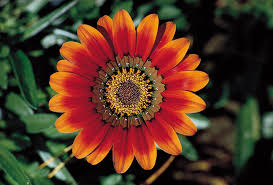

In [5]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/images1.jpeg', width=300,height=200) 

~Image of the flower.


We’re going to process this image by passing it to our prepare_image() function and assign the result to this preprocessed_image variable. We’re then having MobileNet predict on this image by calling mobile.predict() and passing it our preprocessed_image.

In [6]:
preprocessed_image = prepare_image('images1.jpeg')
predictions = mobile.predict(preprocessed_image)

Then, we’re using an ImageNet utility function provided by Keras called decode_predictions(). It returns the top five ImageNet class predictions with the ImageNet class ID, the class label, and the probability. With this, we’ll be able to see the five ImageNet classes with the highest prediction probabilities from our model on this given image. Recall that there are 1000 total ImageNet classes.

In [8]:
results = imagenet_utils.decode_predictions(predictions,top = 5)

In [12]:
results

[[('n11939491', 'daisy', 0.9841703),
  ('n02206856', 'bee', 0.0055864104),
  ('n02219486', 'ant', 0.001431583),
  ('n02190166', 'fly', 0.0009325257),
  ('n13044778', 'earthstar', 0.00087980955)]]

We can see the top 5 classes that model has predicted.

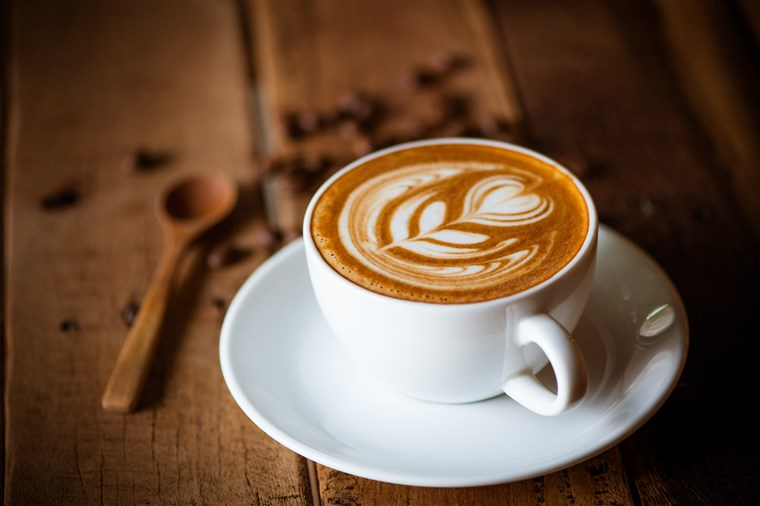

In [25]:
Image(filename='data/MobileNet-samples/image2.jpg', width=300,height=200) 

In [26]:
preprocessed_image = prepare_image('image2.jpg')
predictions = mobile.predict(preprocessed_image)

In [27]:
results = imagenet_utils.decode_predictions(predictions,top = 5)

In [28]:
results

[[('n07920052', 'espresso', 0.93318033),
  ('n07930864', 'cup', 0.04555982),
  ('n03063599', 'coffee_mug', 0.014806351),
  ('n03733805', 'measuring_cup', 0.0014241823),
  ('n03063689', 'coffeepot', 0.0012773387)]]

Again the model predicted perfectly the image.

## Fine-Tuning MobileNet With Keras

### Preparing The Data

In [29]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

ImageDataGenerator.flow_from_directory() function, which yeilds batches of image data from the directory that we pass in with our first parameter.

In [30]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Notice the preprocessing_function parameter we’re supplying to ImageDataGenerator. We’re setting this equal to keras.applications.mobilenet.preprocess_input(). This is going to do the necessary MobileNet preprocessing on the images obtained from flow_from_directory().


To flow_from directory(), we’re passing in the path to the data set, the target_size for the images, and the batch_size we’re choosing to use for training. We do this exact same thing for all three data sets: train, validation, and test.

For the test_batches variable, we’re also supplying one additional parameter, shuffle=False, so that we can later access the corresponding non-shuffled test lables to plot a confusion matrix.

### Model Modification

In [31]:
mobile = tf.keras.applications.mobilenet.MobileNet()

Grab the output from the sixth to last layer of the model and store it in this variable x.


We’ll be using this to build a new model. This new model will consist of the original MobileNet up to the sixth to last layer. We’re not including the last five layers of the original MobileNet.

In [32]:
x = mobile.layers[-6].output

Now, we append an output layer that we’re calling output, which will just be a Dense layer with 2 output nodes, for cat and dog, and we’ll use the softmax activation function.

In [33]:
output = Dense(units=2, activation='softmax')(x)

In [34]:
model = Model(inputs=mobile.input, outputs=output)

* To build the new model, we create an instance of the Model class and specify the inputs to the model to be equal to the input of the original MobileNet, and then we define the outputs of the model to be equal to the output variable we created directly above.

* This creates a new model, which is identical to the original MobileNet up to the original model’s sixth to last layer. We don’t have the last five original MobileNet layers included, but instead we have a new layer, the output layer we created with two output nodes.


we are freezing the weights of all the layers except for the last five layers in our new model, meaning that only the last five layers of the model will be trained.

In [35]:
for layer in model.layers[:-5]:
    layer.trainable = False

## Train Image Classifier Using Transfer Learning - Fine-Tuning MobileNet With Keras


### Compile the Model

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

On this model, we’re first calling compile and specifying the Adam optimizer with a learning rate of .0001. We’re setting the loss to categorical_crossentropy, and our metrics just include accuracy.

### Train the model

In [37]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10
100/100 - 45s - loss: 0.2454 - accuracy: 0.8970 - val_loss: 0.0836 - val_accuracy: 0.9650
Epoch 2/10
100/100 - 42s - loss: 0.0569 - accuracy: 0.9820 - val_loss: 0.0778 - val_accuracy: 0.9750
Epoch 3/10
100/100 - 27s - loss: 0.0467 - accuracy: 0.9820 - val_loss: 0.0715 - val_accuracy: 0.9700
Epoch 4/10
100/100 - 26s - loss: 0.0328 - accuracy: 0.9900 - val_loss: 0.0612 - val_accuracy: 0.9650
Epoch 5/10
100/100 - 26s - loss: 0.0272 - accuracy: 0.9890 - val_loss: 0.0647 - val_accuracy: 0.9700
Epoch 6/10
100/100 - 26s - loss: 0.0282 - accuracy: 0.9920 - val_loss: 0.0575 - val_accuracy: 0.9750
Epoch 7/10
100/100 - 26s - loss: 0.0164 - accuracy: 0.9980 - val_loss: 0.0558 - val_accuracy: 0.9800
Epoch 8/10
100/100 - 26s - loss: 0.0233 - accuracy: 0.9910 - val_loss: 0.0773 - val_accuracy: 0.9650
Epoch 9/10
100/100 - 26s - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.0590 - val_accuracy: 0.9750
Epoch 10/10
100/100 - 26s - loss: 0.0183 - accuracy: 0.9950 - val_loss: 0.0550 - val_accura

### Using The Model For Inference


Before we run the predictions, we’re going to get and format the labels for the test set, and we need these just in order to plot the confusion matrix

In [39]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [40]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [41]:
predictions = model.predict(x=test_batches, verbose=0)

### Visualize Predictions In Confusion Matrix

In [42]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

create this confusion_matrix object called cm, and we set it equal to scikit-learn’s confusion_matrix that we imported at the start of our code in the last episode.

In [43]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [44]:
cm_plot_labels = ['cat','dog']

Confusion matrix, without normalization
[[50  0]
 [ 1 49]]


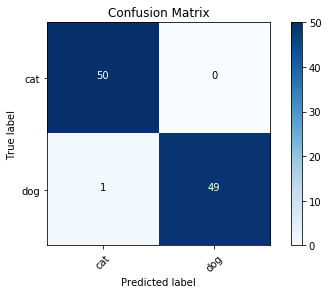

In [45]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
